# Experience Replay

In this project we study the influence of experience replay to improve Q-Learning.
We study the following experience replay techniques,
- Uniform ER
- Prioritized ER
- Hindsight ER
- Combined ER

Our experiements are limited to a subset of the Open-AI Gym's Classic Control environments,
- Cart Pole
- Mountain Car
- Acrobot

Using these ER methods for Q-Learning in the Gym environments, we measure the influence of i.i.d. and TD-error to quantiatively compare the performances.

Our hypothesis is that the effect of i.i.d. has a greater influence in the performance in comparision to the TD-error.

### Setup

In this section we load the required libraries to implement Q-Learning and run the environments of Open-AI Gym.

In [15]:
%matplotlib inline
import os
import sys

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F

import gym
gym.logger.set_level(40)

from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## Q-Learning

Here, we define a Neural Network for the Q function. The forward pass accepts the observation state and outputs the action values.

In [16]:
class QNetwork(nn.Module):
    def __init__(self, input_dim=4, num_hidden=128, output_dim=2):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(input_dim, num_hidden)
        self.l2 = nn.Linear(num_hidden, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.l2(self.relu(self.l1(x)))

In [17]:
# Let's instantiate and test if it works
input_dim = 4
num_hidden = 128
output_dim = 2
torch.manual_seed(1234)
model = QNetwork(input_dim, num_hidden, output_dim)

torch.manual_seed(1234)
test_model = nn.Sequential(
    nn.Linear(input_dim, num_hidden), 
    nn.ReLU(), 
    nn.Linear(num_hidden, output_dim)
)

x = torch.rand(10, 4)

# at this point we do not need backpropagation
with torch.no_grad():
    assert np.allclose(model(x).numpy(), test_model(x).numpy())

Some useful functions for training,

In [18]:
def get_epsilon(it):
    if it == 0:
        return 1
    return np.maximum(1 - it/1000, 0.05)

def select_action(model, state, epsilon):
    with torch.no_grad():
        actionProbs = model(torch.Tensor(state)).numpy()
    action = np.random.choice(len(actionProbs), 1) if np.random.rand() < epsilon else np.argmax(actionProbs)
    return int(action.squeeze())

def copy_model(source_model, target_model):
    target_model.load_state_dict(source_model.state_dict())

def append_sample(transition, model, target_model, discount_factor, memory):
    state, action, reward, next_state, done = transition
    target = model(torch.FloatTensor(state)).data
    old_val = target[0][action]
    target_val = target_model(torch.FloatTensor(next_state)).data
    if done:
        target[0][action] = reward
    else:
        target[0][action] = reward + discount_factor * torch.max(target_val)

    error = abs(old_val - target[0][action])

    memory.push((state, action, reward, next_state, done), error)

In [19]:
def train(memory, model, target_model, batch_size, action_size, optimizer, discount_factor):

    if len(memory) < batch_size:
        return None

    mini_batch, idxs, is_weights = memory.sample(batch_size)
    mini_batch = np.array(mini_batch).transpose()

    states = np.vstack(mini_batch[0])
    actions = list(mini_batch[1])
    rewards = list(mini_batch[2])
    next_states = np.vstack(mini_batch[3])
    dones = mini_batch[4]

    # bool to binary
    dones = dones.astype(int)

    # Q function of current state
    states = torch.Tensor(states)
    pred = model(states)

    # one-hot encoding
    a = torch.LongTensor(actions).view(-1, 1)

    one_hot_action = torch.zeros(batch_size, action_size)
    one_hot_action.scatter_(1, a, 1)

    pred = torch.sum(pred.mul(torch.tensor(one_hot_action)), dim=1)

    # Q function of next state
    next_states = torch.Tensor(next_states)
    next_pred = target_model(next_states).data

    rewards = torch.FloatTensor(rewards)
    dones = torch.FloatTensor(dones)

    # Q Learning: get maximum Q value at s' from target model
    target = rewards + (1 - dones) * discount_factor * next_pred.max(1)[0]
    target = torch.autograd.Variable(target)

    errors = torch.abs(pred - target).data.numpy()

    # update priority
    if isinstance(memory, PrioritizedMemory):
        for i in range(batch_size):
            idx = idxs[i]
            memory.update(idx, errors[i])

    optimizer.zero_grad()

    # MSE Loss function
    loss = F.mse_loss(pred, target)
    loss.backward()

    # and train
    optimizer.step()
    
    return loss.item()

In [20]:
def run_episodes(train, model, target_model, memory, env, num_episodes, batch_size, discount_factor, learn_rate):
    optimizer = optim.Adam(model.parameters(), learn_rate)

    durations = torch.zeros(num_episodes)
    iteration = 0
    
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    scores = []

    for episode in tqdm(range(num_episodes)):
        done = False
        score = 0

        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            action = select_action(model, state, get_epsilon(iteration))

            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            
            # if an action make the episode end, then gives penalty of -100
            reward = reward if not done or score == 499 else -10

            transition = (state, action, reward, next_state, done)

            append_sample(transition, model, target_model, discount_factor, memory)

            train(memory, model, target_model, batch_size, action_size, optimizer, discount_factor)

            score += reward
            state = next_state

            durations[episode] += 1
            iteration += 1

            if done:
                # every episode update the target model to be same with model
                copy_model(model, target_model)

                # every episode, plot the play time
                score = score if score == 500 else score + 10
                scores.append(score)
    return durations

## Environment

We load the necessary Gym environments required for our experiments.

In [35]:
environments = ["CartPole-v0", "Acrobot-v1", "MountainCar-v0"]
envs = {}

print('Environment \t\t State Space \t Action Space')
print('----------- \t\t ----------- \t ------------')
for environment in environments:
    env = gym.envs.make(environment)
    envs[environment] = env
    print('{} \t\t {} \t {}'.format(
        environment,
        env.observation_space,
        env.action_space)
    )

Environment 		 State Space 	 Action Space
----------- 		 ----------- 	 ------------
CartPole-v0 		 Box(4,) 	 Discrete(2)
Acrobot-v1 		 Box(6,) 	 Discrete(3)
MountainCar-v0 		 Box(2,) 	 Discrete(3)


## Experience Replay

### ReplayMemory

In [36]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition, error=None): # extra None to have the same behaviour as PER
        self.memory.append(transition)

    def sample(self, batch_size):
        raise NotImplementedError('Function sample is not defined')

    def __len__(self):
        return len(self.memory)

### No Experience Replay and Uniform Experience Replay

In [37]:
class NoneMemory(ReplayMemory):
    def sample(self, batch_size):
        return self.memory[-batch_size:], None, None # extra Nones to have the same behaviour as PER


class UniformMemory(ReplayMemory):
    def sample(self, batch_size):
        index = np.random.choice(len(self), batch_size, replace=False)
        return [self.memory[i] for i in index], None, None # extra Nones to have the same behaviour as PER

### Prioritized Experience Replay

In [38]:
# Source: https://github.com/rlcode/per

# SumTree
# a binary tree data structure where the parent’s value is the sum of its children
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])


class PrioritizedMemory:  # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.6
    beta = 0.4
    beta_increment_per_sampling = 0.001

    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.capacity = capacity

    def _get_priority(self, error):
        return (error + self.e) ** self.a
    
    def __len__(self):
        return self.tree.n_entries

    def push(self, sample, error):
        p = self._get_priority(error)
        self.tree.add(p, sample)

    def sample(self, n):
        batch = []
        idxs = []
        segment = self.tree.total() / n
        priorities = []

        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            priorities.append(p)
            batch.append(data)
            idxs.append(idx)

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return batch, idxs, is_weight

    def update(self, idx, error):
        p = self._get_priority(error)
        self.tree.update(idx, p)

Test if the memory module works as expected,

In [39]:
capacity = 10
memory = NoneMemory(capacity)

# Sample a transition
s = env.reset()
a = env.action_space.sample()
s_next, r, done, _ = env.step(a)

# Push a transition
memory.push((s, a, r, s_next, done))

# Sample a batch size of 1
print(memory.sample(1)[0][0])

(array([-0.57310345,  0.        ]), 0, -1.0, array([-0.57373353, -0.00063008]), False)


Test if the train module works as expected,

In [40]:
# settings
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
input_dim = 2
output_dim = 2

model = QNetwork(input_dim, num_hidden, output_dim)
optimizer = optim.Adam(model.parameters(), learn_rate)

# setup memory
transition = memory.sample(1)[0][0]
memory = UniformMemory(10 * batch_size)

# fill with dummy data
for i in range(batch_size):
    memory.push(transition)

# must print a loss
print(train(memory, model, model, batch_size, output_dim, optimizer, discount_factor))

0.9069595336914062


# Run Experiments

In [41]:
def run(er_type='uniform', environment="CartPole-v0"):
    # load environment
    env = envs[environment]
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    num_hidden = 128

    # init networks
    model = QNetwork(state_size, num_hidden, action_size)
    target_model = QNetwork(state_size, num_hidden, action_size)

    copy_model(model, target_model)

    # run settings
    batch_size = 64
    discount_factor = 0.8
    learn_rate = 1e-3
    memory_size = 10000
    num_episodes = 200
    
    er_types = {
        'none': NoneMemory,
        'uniform': UniformMemory,
        'prioritized': PrioritizedMemory
    }

    memory = er_types[er_type](memory_size)
    seed = 42  # This is not randomly chosen

    # We will seed the algorithm (before initializing QNetwork!) for reproducability
    random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)

    episode_durations = run_episodes(train, model, target_model, memory, env, num_episodes, batch_size, discount_factor, learn_rate)
    return episode_durations.numpy()

## Results

In [51]:
exp_replays = ['none', 'uniform', 'prioritized']
environemnts = ["CartPole-v0", "Acrobot-v1", "MountainCar-v0"] # one from ["CartPole-v0", "Acrobot-v1", "MountainCar-v0"]


# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


def grid_search():
    results = {}
    runs_values = runs.keys()
    for environment in environments:
        results[environment]=[]
        for er_type in exp_replays:
            print("Running {} in {}".format(er_type, environment))
            results[environment].append(smooth(run(er_type, environment), 10))
    return results


def test_run(environment="CartPole-v0"):
    for er_type in exp_replays:
        plt.plot(smooth(run(er_type, environment), 10))
    plt.title('Episode durations per episode')
    plt.legend(exp_replays)
    
# use results and then next cell for plotting - no need to get results multiple times
results = grid_search()
# test_run()


  0%|          | 0/200 [00:00<?, ?it/s]

Running none in CartPole-v0



  0%|          | 0/200 [00:00<?, ?it/s]

Running uniform in CartPole-v0



100%|██████████| 200/200 [00:33<00:00,  3.89it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Running prioritized in CartPole-v0



  0%|          | 0/200 [00:00<?, ?it/s]

Running none in Acrobot-v1



100%|██████████| 200/200 [01:32<00:00,  2.07it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Running uniform in Acrobot-v1



100%|██████████| 200/200 [02:54<00:00,  1.31s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

Running prioritized in Acrobot-v1



 92%|█████████▏| 184/200 [03:24<00:18,  1.15s/it]


100%|██████████| 200/200 [03:43<00:00,  1.18s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

Running none in MountainCar-v0



  0%|          | 0/200 [00:00<?, ?it/s]

Running uniform in MountainCar-v0



100%|██████████| 200/200 [00:46<00:00,  3.48it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Running prioritized in MountainCar-v0



100%|██████████| 200/200 [01:26<00:00,  2.31it/s]

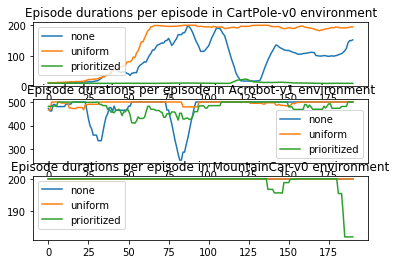

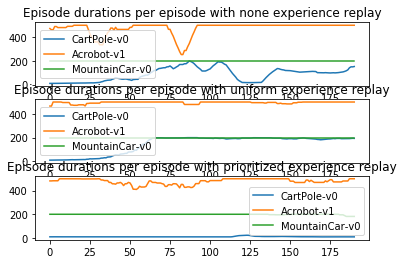

In [62]:
def grid_graphs(: 
    for env in environments:
        plt.subplot(3,1, environments.index(env)+1)
        for i in range(len(exp_replays)):
            plt.plot(results[env][i])
        plt.title('Episode durations per episode in {} environment'.format(env))
        plt.legend(exp_replays)
    plt.show()

    for i in range(len(exp_replays)):
        plt.subplot(3,1, i+1)
        for env in environments:
            plt.plot(results[env][i])
        plt.title('Episode durations per episode with {} experience replay'.format(exp_replays[i]))
        plt.legend(environments)
    plt.show()
    
# grid_graphs()
